# Laboratorium 4: PyTorch Lightning — Baseline vs Transfer Learning (PathMNIST)

W tym ćwiczeniu chcemy wykozrystać **PyTorch Lightning**, który jest wysokopoziomowym frameworkiem nad PyTorchem, który porządkuje i automatyzuje kod trenowania sieci neuronowych.
Poprawia on czytelność kodu, ułatwia obsługę sprzętu oraz przyspiesza przeprowadzenie różnych eksperymentów.

**Cele:**
- zbudować prostą sieć CNN w **PyTorch Lightning** jako **baseline** (224×224),
- wykonać **Transfer Learning** z **ResNet18 (ImageNet)** jako model porównawczy (224×224),
- użyć **EarlyStopping** i **ModelCheckpoint**,
- porównać wyniki (Accuracy, Macro-F1) i obejrzeć **macierz pomyłek**.

**Dataset:** **PathMNIST (MedMNIST)** — automatycznie pobierany, 9 klas (RGB, 224x224×3). Jeśli chcemy zmniejszyć czas pobierania danych to można podać mniejszą rozdzielczość, ale dla transfer learningu z ResNet18 najlepiej podawać dane **przeskalowane do 224×224**. Zawiera on obrazki histopatologiczne do klasyfikacji zmian tkankowych.

> Najpierw trenujemy małą sieć CNN, zapisujemy najlepszy checkpoint, testujemy.
> Potem trenujemy model bazujący na ResNet18 z zamrożonym backbone i wykonujemy test najlepszej wersji oraz porównanie wyników. Potem opcjonalnie **odmrażamy** backbone (fine-tuning).

## 0) Instalacja i importy

In [1]:
!pip -q install pytorch-lightning torchmetrics medmnist scikit-learn --extra-index-url https://download.pytorch.org/whl/cpu

import os, random, numpy as np, matplotlib.pyplot as plt
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import pytorch_lightning as pl
from pytorch_lightning import LightningModule, LightningDataModule, Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassConfusionMatrix

import medmnist
from medmnist import PathMNIST, INFO
from torchvision.models import resnet18, ResNet18_Weights

SEED = 42
def set_seed(seed=SEED):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
set_seed()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device, '| PyTorch Lightning:', pl.__version__)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 832.4/832.4 kB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 12.6 MB/s eta 0:00:00
Device: cuda | PyTorch Lightning: 2.5.5


## 1) Dane: PathMNIST (auto-download) i podgląd

Skrypt automatycznie pobiera zbiór **PathMNIST**. Poniższy kod sprawdza rozmiar danych i etykiety.
Wyświetlone zostaje również 6 pierwszych próbek z tego zbioru. W tym przypadku będziemy przetwarzać dane RGB o rozdzielczości 224x224, co znacznie wydłuża czas pobierania i przetwarzania danych. Dane tej rozdzielczości były wykorzystane w zbiorze **ImageNet**, przez co stała się ona domyślna dla wielu popularnych architektur wykorzystywanych przez transfer learning.

Opis: The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-HE-100K into training and validation set with a ratio of 9:1. The CRC-VAL-HE-7K is treated as the test set.
Liczba klas: 9 | label map: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}


100%|██████████| 1.07G/1.07G [09:53<00:00, 1.80MB/s]


Rozmiary: 89996 10004 7180


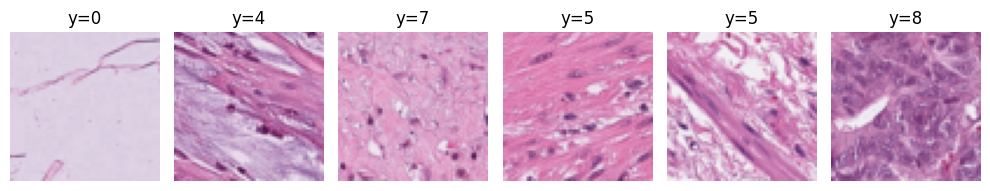

In [2]:
DATA_ROOT = './data/medmnist'
os.makedirs(DATA_ROOT, exist_ok=True)

info = INFO['pathmnist']
NUM_CLASSES = len(info['label'])
print('Opis:', info['description'])
print('Liczba klas:', NUM_CLASSES, '| label map:', info['label'])

IMG_SIZE = 64

train_raw = PathMNIST(split='train', download=True, root=DATA_ROOT, as_rgb=True, size=IMG_SIZE)
val_raw   = PathMNIST(split='val',   download=True, root=DATA_ROOT, as_rgb=True, size=IMG_SIZE)
test_raw  = PathMNIST(split='test',  download=True, root=DATA_ROOT, as_rgb=True, size=IMG_SIZE)
print('Rozmiary:', len(train_raw), len(val_raw), len(test_raw))

# Podgląd przykładowych obrazów
fig, axes = plt.subplots(1, 6, figsize=(10,2))
for i in range(6):
    img, y = train_raw[i]
    axes[i].imshow(np.array(img))
    axes[i].set_title(f'y={int(y.squeeze().item())}')
    axes[i].axis('off')
plt.tight_layout(); plt.show()

## Zadanie 1 – Transformacje i DataModule

Konieczne jest zaimplementowanie dwóch zestawów augmentacji. Pierwszy dla naszej sieci, a drugi dla użytej przez transfer learning. Różnić się one muszą normalizacją.
1. Dla naszej, prostej architektury wykorzystujemy standardową normalizację `transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])`.
2. Dla sieciach preuczonych na ImageNet musimy wykorzystać `transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])`.
3. Oprócz tego możemy wykorzystać odbicie w poziomie z prawdopodobieństwem 50% i rotację o maksymalny kąt 10 stopni. Oprócz tego oczywiście musimy skonwertować dane do Tensora.
4. Następnie musimy zaimplementować klasę, która będzie zarządzać wczytywaniem danych. Powinna ona dziedziczyć po klasie `LightningDataModule`. Musimy dla niej zaimplementować kilka metod:
    - `__init__`, dla której przekazujemy i zapamiętujemy transformacje dla augmentacji, `batch_size` i `num_workers`.
    - `setup(self, stage=None)` powinna wczytać zbiory treningowy, walidacyjny i testowy. Pamiętaj o przekazaniu rozmiaru `size` i augmentacji danych.
    - `train_dataloader`, `val_dataloader`, `test_dataloader` powinny zwracać DataLoadery dla poszczególnych zbiorów.
5. Następnie stwórz obiekty tej klasy oraz wykonaj metodę `.setup()`. Pobierz próbkę danych: `x, y = next(iter(dm.train_dataloader()))` i  sprawdź jej rozmiar.

In [3]:
# Zadanie 1
rot = transforms.RandomRotation(degrees=10)
flip = transforms.RandomHorizontalFlip(p=0.5)

own_val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]),
])

pl_val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

own_train_transform = transforms.Compose([
    own_val_transform,
    flip,
    rot,
])

pl_train_transforms = transforms.Compose([
    pl_val_transforms,
    flip,
    rot,
])


class MedMNISTDataModule(LightningDataModule):
    def __init__(self, data_dir, train_transform, val_test_transform,
                 batch_size=64, num_workers=4, img_size=64):
        super().__init__()
        self.data_dir = data_dir
        self.train_transform = train_transform
        self.val_test_transform = val_test_transform
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.img_size = img_size

    def setup(self, stage=None):
        # Wczytanie zbiorów danych z odpowiednimi transformacjami
        self.train_dataset = PathMNIST(split='train', download=True,
                                       root=self.data_dir, as_rgb=True,
                                       transform=self.train_transform,
                                       size=self.img_size)
        self.val_dataset = PathMNIST(split='val', download=True,
                                     root=self.data_dir, as_rgb=True,
                                     transform=self.val_test_transform,
                                     size=self.img_size)
        self.test_dataset = PathMNIST(split='test', download=True,
                                      root=self.data_dir, as_rgb=True,
                                      transform=self.val_test_transform,
                                      size=self.img_size)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size,
                          shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size,
                          shuffle=False, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size,
                          shuffle=False, num_workers=self.num_workers)


BATCH_SIZE = 64
NUM_WORKERS = 4

dm = MedMNISTDataModule(DATA_ROOT, own_train_transform, own_val_transform,
                        batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, img_size=IMG_SIZE)
dm.setup()

x, y = next(iter(dm.train_dataloader()))
print('Rozmiar danych:', x.shape, '| Rozmiar etykiet:', y.shape)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Rozmiar danych: torch.Size([64, 3, 64, 64]) | Rozmiar etykiet: torch.Size([64, 1])


## Zadanie 2 – Lightning **Baseline**: prosta CNN + metryki + optymalizator

Teraz stworzymy klasę prostej sieci z wykorzystaniem **PyTorch Lightning**. Klasa ta musi posiadać kilka metod: `__init__(self, ...)`, `forward(self, x)`, `configure_optimizers(self)`, `training_step(self, batch, batch_idx)`. Oprócz tego dobrze jest zaimplementować metody `validation_step(self, batch, batch_idx)`, `test_step(self, batch, batch_idx)`.
1. Do inicjalizacji przakaż liczbę klas oraz learning rate. Na początku zainicjalizuj klasę bazową `super().__init__()`, zapisz przekazane parametry `self.save_hyperparameters()` oraz zdefiniuj wykorzystywane warstwy. Chcemy użyć 5 warstw konwolucyjnych z ReLU i MaxPoolingiem, 3 warstwy w pełni połączone i dropout po dwóch pierwszych warstwach w pełni połączonych. Dodatkowo musimy zdefiniować obiekty do obliczania metryk. Chcemy obliczać dokładność dla zbiorów treningowego, walidacyjnego i testowego `MulticlassAccuracy` (przekazujemy jej liczbę klas `num_classes`), F1-score dla zbiorów walidacyjnego i testowego `MulticlassF1Score` (przekazujemy jej liczbę klas `num_classes` i metodę obliczania średniej - chcemy obliczyć `'macro'`) oraz macierz pomyłek dla zbioru testowego `MulticlassConfusionMatrix` (przekazujemy jej liczbę klas `num_classes`).
2. W metodzie `forward(self, x)` wykonujemy kolejne obliczenia sieci podobnie jak w poprzednich ćwiczeniach.
3. W metodzie `configure_optimizers(self)` musimy zdefiniować optymalizator. Wykorzystamy `torch.optim.Adam`. Oprócz tego chcemy zastosować LR scheduler. Jego zadaniem jest zmiana i dostosowywanie learning rate w trakcie uczenia. Wykorzystamy `torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=6)`, który zmienia learning rate zgodnie z funkcją kosinusoidalną. Metoda ta powinna zwracać słownik z odpowiednimi polami: `{'optimizer': opt, 'lr_scheduler': sch}`.
4. Pozostałe metody zawierają obliczenia, które wcześniej wykonywane były odpowiednio w pętlach treningowych, walidacyjnych i testowych. Oprócz tego musimy tam dodać obliczanie i logowanie metryk. Aby obliczyć metrykę musimy tylko przekazać jej obliczone predykcje i rzeczywiste etykiety. Logować chcemy zdefiniowane wcześniej metryki oraz stratę dla zbiorów treningowych i walidacyjnych. W tym celu wykorzystujemy funkcję `self.log`, której przyekazujemy argumenty:
    - nazwę logowanej wartości,
    - wartość,
    - `on_step` - czy logujemy po każdym kroku (ustawiamy na `False`),
    - `on_epoch` - czy logujemy po każdej epoce (ustawiamy na `True`),
    - `prog_bar` - czy wartość jest wyświetlana na pasku postępu (ustawiamy na `True`).

In [4]:
# Zadanie 2
class LightningCNN(LightningModule):
  def __init__(self, num_classes, lr=1e-3):
    super().__init__()
    self.save_hyperparameters()

    self.conv_layers = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),

        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),

        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),

        nn.Conv2d(128, 256, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),

        nn.Conv2d(256, 512, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )

    self.fc_layers = nn.Sequential(
        nn.Linear(512 * 2 * 2, 512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(256, num_classes)
    )

    self.train_acc = MulticlassAccuracy(num_classes=num_classes)
    self.val_acc = MulticlassAccuracy(num_classes=num_classes)
    self.test_acc = MulticlassAccuracy(num_classes=num_classes)

    self.val_f1 = MulticlassF1Score(num_classes=num_classes, average='macro')
    self.test_f1 = MulticlassF1Score(num_classes=num_classes, average='macro')

    self.test_cm = MulticlassConfusionMatrix(num_classes=num_classes)

  def forward(self, x):
    x = self.conv_layers(x)
    x = torch.flatten(x, 1)
    x = self.fc_layers(x)
    return x

  def configure_optimizers(self):
    opt = torch.optim.Adam(self.parameters(), lr=self.hparams.lr)
    sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=6)

    return {"optimizer": opt, "lr_scheduler": sch}

  def training_step(self, batch, batch_idx):
    x, y = batch
    out = self(x)
    loss = F.cross_entropy(out, y.squeeze())

    preds = torch.argmax(out, dim=1)
    acc = self.train_acc(preds, y.squeeze())

    self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
    self.log("train_acc", acc, on_step=False, on_epoch=True, prog_bar=True)

    return loss

  def validation_step(self, batch, batch_idx):
    x, y = batch
    out = self(x)
    loss = F.cross_entropy(out, y.squeeze())

    preds = torch.argmax(out, dim=1)
    acc = self.val_acc(preds, y.squeeze())
    f1 = self.val_f1(preds, y.squeeze())

    self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
    self.log("val_acc", acc, on_step=False, on_epoch=True, prog_bar=True)
    self.log("val_f1", f1, on_step=False, on_epoch=True, prog_bar=True)

  def test_step(self, batch, batch_idx):
    x, y = batch
    out = self(x)
    loss = F.cross_entropy(out, y.squeeze())

    preds = torch.argmax(out, dim=1)
    acc = self.test_acc(preds, y.squeeze())
    f1 = self.test_f1(preds, y.squeeze())
    cm = self.test_cm(preds, y.squeeze())

    self.log("test_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
    self.log("test_acc", acc, on_step=False, on_epoch=True, prog_bar=True)
    self.log("test_f1", f1, on_step=False, on_epoch=True, prog_bar=True)

    return cm


## Zadanie 3 – Trening **Baseline** z EarlyStopping + Checkpoint

Teraz chcemy przeprowadzić trening dla zaimplementowanej sieci.
1. Najpierw zdefiniuj obiekt klasy.
2. Chcemy dodatkowo wykorzystać early stopping. Pozwala on na wcześniejsze zatrzymanie treningu, jeśli od zadanej liczby epok nie poprawiła się zadana metryka dla zbioru walidacyjnego. W tym celu tworzymy obiekt `EarlyStopping`, któremu przekazujemy argumenty: `monitor` - nazwa obserwowanej metryki z logowania, `mode` - chcemy maksymalizować czy minimalizować, `patience` - po ilu epokach bez poprawy przerywamy trening.
3. Dodajemy również automatyczne zapisywanie najlepszego modelu za pomocą obiektu `ModelCheckpoint`. Przekazujemy argumenty: `monitor` - nazwa obserwowanej metryki z logowania, `mode` - chcemy maksymalizować czy minimalizować, `save_top_k` - ile najlepszych modeli zapisujemy, `filename` - nazwę zapisywanego pliku, np. `'baseline-small-{epoch:02d}-{val_f1:.3f}'`.
4. Aby przeprowadzić trening tworzymy obiekt `Trainer`, której przekazujemy argumenty: `max_eopch` - maksymalna liczba epok, `accelerator` - określa urządzenie do treningu (`'auto'` wybiera GPU jeśli dostępne, inaczej CPU), `devices` - ile urządzeń (GPU/CPU) używać, `callbacks` - lista callbacków używanych w treningu (u nas early stopping i checkpoint).
5. Następnie wywołujemy metodę `.fit`, której przekazujemy trenowaną klasę i obiekt klasy zarządzającej danymi jako argument `datamodule`.
6. Powinny zostać wyświetlona informacje o zaprojektowanej architekturze. Przeanalizuj je. Zwróć uwagę na liczbę parametrów sieci.

In [5]:
# Zadanie 3
lightning_model = LightningCNN(num_classes=NUM_CLASSES, lr=1e-3)

stop = EarlyStopping(monitor='val_f1', mode='max', patience=4)

checkpoint = ModelCheckpoint(monitor='val_f1', mode='max',
                             save_top_k=1, filename='baseline-small-{epoch:02d}-{val_f1:.3f}')

trainer = Trainer(max_epochs=25, accelerator='auto', devices=1,
                  callbacks=[stop, checkpoint])

trainer.fit(lightning_model, dm)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name        | Type                      | Params | Mode 
------------------------------------------------------------------
0 | conv_layers | Sequential                | 1.6 M  | train
1 | fc_layers   | Sequential                | 1.2 M  | train
2 | train_acc   | MulticlassAccuracy        | 0      | train
3 | val_acc     | MulticlassAccuracy        | 0      | train
4 | test_acc    | MulticlassAccuracy        | 0      | train
5 | val_f1      | MulticlassF1Score         | 0      | train
6 | test_f1     | MulticlassF1Score         | 0      | train
7 | test_cm     | MulticlassConfusionMatrix | 0      | train
--------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

## Zadanie 4 – Test baseline + macierz pomyłek

Teraz chcemy przeprowadzić test wytrenowanej sieci.
1. Najpierw musimy wczytać model dla którego osiągnięto najlepszy wynik (checkpoint). Wykorzystujemy w tym celu metodę `.load_from_checkpoint` dla klasy implementującej naszą sieć. Jako argument przekazujemy ścieżkę do checkpointu `ckpt.best_model_path`.
2. Aby przeprowadzić test należy wywołać matodę `.test` trainera. Pierwszym argumentem jest obiekt z wczytanego checkpointu, a drugim jest obiekt zarządzający danymi jako `datamodule`.
3. Confusion matrix jest obliczane przez wywołanie i przypisanie wyjścia dla `best_baseline.test_cm.compute().cpu().numpy()`. Następnie wyświetlamy macierz pomyłek. Wcześniejsze wywołanie metody `.test` powinno spowodować wyświetlenie logowanych metryk dla zbioru testowego.

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9226125478744507     │
│          test_f1          │    0.9097369909286499     │
│         test_loss         │    0.22322066128253937    │
└───────────────────────────┴───────────────────────────┘

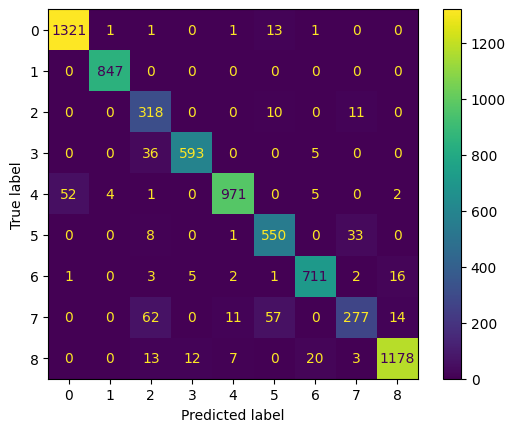

In [6]:
# Zadanie 4
best_model_path = checkpoint.best_model_path
best_baseline = LightningCNN.load_from_checkpoint(best_model_path)

trainer.test(best_baseline, dm)

cm = best_baseline.test_cm.compute().cpu().numpy()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=info['label'])
disp.plot()
plt.show()

## Zadanie 5 – Lightning **Transfer Learning**: ResNet18 (pretrained, head-only) + metryki

Teraz chcemy wykorzystać backbone sieci, która została już wcześniej wytrenowana. Backbone to główna część sieci, odpowiedzialna za ekstrakcję cech (feature extraction). Zwykle jest to duża, sprawdzona architektura, używana jako uniwersalny ekstraktor reprezentacji. Head to końcowa część sieci, która dostosowuje wyekstrahowane cechy do konkretnego zadania. Jako backbone chcemy wykorzystać ResNet18, a jako head prostą, w pełni połączoną, warstwę liniową.

1. Kod całej klasy jest bardzo podobny do zaimplementowanej wcześniej. Do argumentów inicjalizacji dodajemy flagę oznaczającą zamrożenie backbone (jego parametry nie będę zmieniane w trakcie treningu).
2. Wagi wczytujemy za pomocą `weights = ResNet18_Weights.IMAGENET1K_V1`. Następnie musimy je przekazań do funkcji `resnet18` jako argument `weights`.
3. W ResNecie na końcu jest warstwa w pełni połączona (jako head). Liczbę jej wejść możemy sprawdzić za pomocą `self.backbone.fc.in_features`.Na podstawie tej wielkości i liczby klas modyfikujemy tą ostatnią warstwę: `self.backbone.fc = nn.Linear(in_features, num_classes)`.
4. Stwórz metryki skuteczności.
5. Sprawdź flagę zamrożenia backbone. Jeśli jest ustawione, to wykonaj kod (lub włóż do funkcji):
```Python
    for name, p in self.backbone.named_parameters():
        if not name.startswith('fc'):
            p.requires_grad = False
```
6. Zaimplementuj metodę `forward`.
7. Zaimplementuj metodę `configure_optimizers`. W tym wypadku przekazując parametry do optymalizatora musimy usunąć te, dla których wyłączyliśmy obliczanie gradientu: `params = filter(lambda p: p.requires_grad, self.parameters())`.
8. Pozostałe metody są takie same jak we wcześniejszej klasie.

In [7]:
# Zadanie 5
class ResNet18Lightning(LightningModule):
  def __init__(self, num_classes: int, lr: float = 1e-3, freeze_backbone: bool = True):
    super().__init__()
    self.save_hyperparameters()

    # ResNet18 z wagami ImageNet
    weights = ResNet18_Weights.IMAGENET1K_V1
    self.backbone = resnet18(weights=weights)

    # Modyfikacja head
    in_features = self.backbone.fc.in_features
    self.backbone.fc = nn.Linear(in_features, num_classes)

    self.train_acc = MulticlassAccuracy(num_classes=num_classes)
    self.val_acc = MulticlassAccuracy(num_classes=num_classes)
    self.test_acc = MulticlassAccuracy(num_classes=num_classes)

    self.val_f1 = MulticlassF1Score(num_classes=num_classes, average='macro')
    self.test_f1 = MulticlassF1Score(num_classes=num_classes, average='macro')

    self.test_cm = MulticlassConfusionMatrix(num_classes=num_classes)

    if freeze_backbone:
      for name, p in self.backbone.named_parameters():
        if not name.startswith('fc'):
          p.requires_grad = False

  def forward(self, x):
    return self.backbone(x)

  def configure_optimizers(self):
    if self.hparams.freeze_backbone:
      params = filter(lambda p: p.requires_grad, self.backbone.parameters())
    else:
      params = self.backbone.parameters()

    opt = torch.optim.Adam(params, lr=self.hparams.lr)
    sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=6)

    return {"optimizer": opt, "lr_scheduler": sch}

  def training_step(self, batch, batch_idx):
    x, y = batch
    out = self(x)
    loss = F.cross_entropy(out, y.squeeze())

    preds = torch.argmax(out, dim=1)
    acc = self.train_acc(preds, y.squeeze())

    self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
    self.log("train_acc", acc, on_step=False, on_epoch=True, prog_bar=True)

    return loss

  def validation_step(self, batch, batch_idx):
    x, y = batch
    out = self(x)
    loss = F.cross_entropy(out, y.squeeze())

    preds = torch.argmax(out, dim=1)
    acc = self.val_acc(preds, y.squeeze())
    f1 = self.val_f1(preds, y.squeeze())

    self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
    self.log("val_acc", acc, on_step=False, on_epoch=True, prog_bar=True)
    self.log("val_f1", f1, on_step=False, on_epoch=True, prog_bar=True)

  def test_step(self, batch, batch_idx):
    x, y = batch
    out = self(x)
    loss = F.cross_entropy(out, y.squeeze())

    preds = torch.argmax(out, dim=1)
    acc = self.test_acc(preds, y.squeeze())
    f1 = self.test_f1(preds, y.squeeze())
    cm = self.test_cm(preds, y.squeeze())

    self.log("test_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
    self.log("test_acc", acc, on_step=False, on_epoch=True, prog_bar=True)
    self.log("test_f1", f1, on_step=False, on_epoch=True, prog_bar=True)

    return cm

  def unfreeze_backbone(self):
    for p in self.backbone.parameters():
      p.requires_grad = True


## Zadanie 6 – Trening Transfer Learning (head-only) z EarlyStopping + Checkpoint

Przeprowadź trening dla zaimplementowanej sieci z TL i zamrożonym backbone.

In [8]:
# Zadanie 6
resnet_model = ResNet18Lightning(num_classes=NUM_CLASSES, lr=1e-3, freeze_backbone=True)

stop = EarlyStopping(monitor='val_f1', mode='max', patience=4)

checkpoint = ModelCheckpoint(monitor='val_f1', mode='max',
                             save_top_k=1, filename='resnet18-{epoch:02d}-{val_f1:.3f}')

trainer = Trainer(max_epochs=25, accelerator='auto', devices=1,
                  callbacks=[stop, checkpoint])

trainer.fit(resnet_model, dm)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 182MB/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                      | Params | Mode 
----------------------------------------------------------------
0 | backbone  | ResNet                    | 11.2 M | train
1 | train_acc | MulticlassAccuracy        | 0      | train
2 | val_acc   | MulticlassAccuracy        | 0      | train
3 | test_acc  | MulticlassAccuracy        | 0      | train
4 | val_f1    | MulticlassF1Score         | 0      | train
5 | test_f1   | MulticlassF1Score         | 0      | train
6 | test_cm   | MulticlassConfusionMatrix | 0      | train
-----------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

## Zadanie 7 – Test transfer + macierz pomyłek + porównanie metryk (Baseline vs Transfer)

Sprawdź metryki dla zbioru testowego i wyświetl macierz pomyłek.

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7916346192359924     │
│          test_f1          │    0.7790787220001221     │
│         test_loss         │    0.4691601097583771     │
└───────────────────────────┴───────────────────────────┘

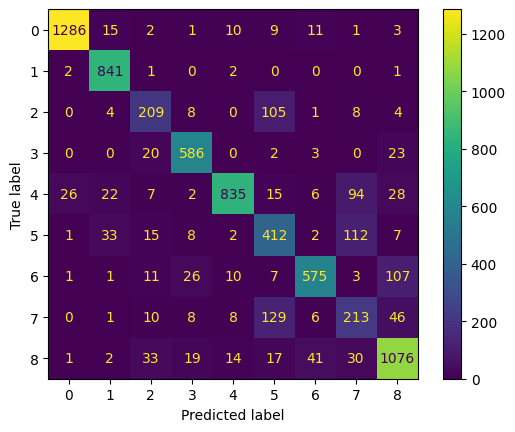

Baseline - Test Accuracy: 0.922, F1: 0.918
Transfer Learning - ResNet18 - Test Accuracy: 0.795, F1: 0.794


In [9]:
# Zadanie 7
best_resnet_model_path = checkpoint.best_model_path
best_resnet = ResNet18Lightning.load_from_checkpoint(best_resnet_model_path)

trainer.test(best_resnet, dm)

cm = best_resnet.test_cm.compute().cpu().numpy()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=info['label'])
disp.plot()
plt.show()

# Porównanie Accuracy i F1-score dla zbioru testowego
baseline_acc = best_baseline.test_acc.compute().item()
baseline_f1 = best_baseline.test_f1.compute().item()

resnet_acc = best_resnet.test_acc.compute().item()
resnet_f1 = best_resnet.test_f1.compute().item()

print(f"Baseline - Test Accuracy: {baseline_acc:.3f}, F1: {baseline_f1:.3f}")
print(f"Transfer Learning - ResNet18 - Test Accuracy: {resnet_acc:.3f}, F1: {resnet_f1:.3f}")

## Zadanie 8 – Fine tuning

W tym przypadku chcemy odmrozić wagi backbone i douczyć całą sieć.
1. Do zaimplementowanej wcześniej funkcji dodajemy funkcję, która pozwala na odmrożenie wag backbone:
```Python
    for p in self.backbone.parameters():
        p.requires_grad = True
```
2. Załaduj najlepszy checkpoint trenowanej sieci.
3. Odmroź backbone.
4. Zmniejsz learning rate: `fine_tune_model.hparams.lr = 1e-4`.
5. Dodaj early stopping i zapisywanie najlepszego checkpointu.
6. Przygotuj trainer i uruchom trening sieci.

In [10]:
# Zadanie 8
fine_tune_model = ResNet18Lightning.load_from_checkpoint(best_resnet_model_path)
fine_tune_model.unfreeze_backbone()

fine_tune_model.hparams.lr = 1e-4

stop = EarlyStopping(monitor='val_f1', mode='max', patience=4)

checkpoint = ModelCheckpoint(monitor='val_f1', mode='max',
                             save_top_k=1, filename='fine-resnet18-{epoch:02d}-{val_f1:.3f}')

trainer = Trainer(max_epochs=25, accelerator='auto', devices=1,
                  callbacks=[stop, checkpoint])

trainer.fit(fine_tune_model, dm)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                      | Params | Mode 
----------------------------------------------------------------
0 | backbone  | ResNet                    | 11.2 M | train
1 | train_acc | MulticlassAccuracy        | 0      | train
2 | val_acc   | MulticlassAccuracy        | 0      | train
3 | test_acc  | MulticlassAccuracy        | 0      | train
4 | val_f1    | MulticlassF1Score         | 0      | train
5 | test_f1   | MulticlassF1Score         | 0      | train
6 | test_cm   | MulticlassConfusionMatrix | 0      | train
----------------------------------------------------------------
11.2 M    Trainable pa

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

## Zadanie 9 – Test najlepszego checkpointu i podsumowanie wszystkich wyników

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9210215210914612     │
│          test_f1          │    0.9079017639160156     │
│         test_loss         │    0.24012324213981628    │
└───────────────────────────┴───────────────────────────┘

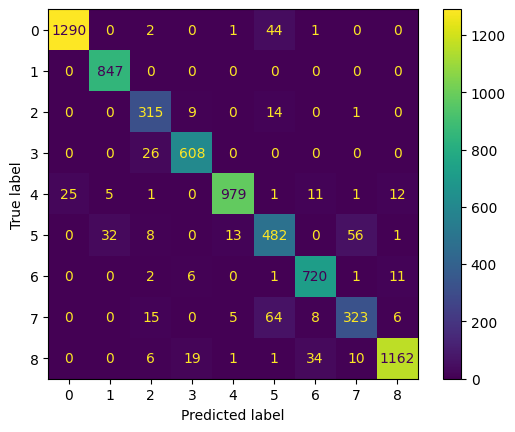

Baseline - Test Accuracy: 0.922, F1: 0.918
Transfer Learning - ResNet18 - Test Accuracy: 0.795, F1: 0.794
Fine tuning - ResNet18 - Test Accuracy: 0.922, F1: 0.917


In [11]:
# Zadanie 9
best_fine_model_path = checkpoint.best_model_path
best_fine = ResNet18Lightning.load_from_checkpoint(best_fine_model_path)

trainer.test(best_fine, dm)

cm = best_fine.test_cm.compute().cpu().numpy()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=info['label'])
disp.plot()
plt.show()

# Porównanie Accuracy i F1-score dla zbioru testowego
baseline_acc = best_baseline.test_acc.compute().item()
baseline_f1 = best_baseline.test_f1.compute().item()

resnet_acc = best_resnet.test_acc.compute().item()
resnet_f1 = best_resnet.test_f1.compute().item()

fine_acc = best_fine.test_acc.compute().item()
fine_f1 = best_fine.test_f1.compute().item()

print(f"Baseline - Test Accuracy: {baseline_acc:.3f}, F1: {baseline_f1:.3f}")
print(f"Transfer Learning - ResNet18 - Test Accuracy: {resnet_acc:.3f}, F1: {resnet_f1:.3f}")
print(f"Fine tuning - ResNet18 - Test Accuracy: {fine_acc:.3f}, F1: {fine_f1:.3f}")